In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import time
import importlib

from art.attacks import FastGradientMethod, ProjectedGradientDescent, CarliniL2Method
from art.classifiers import PyTorchClassifier

# Hyper Parameters
EPOCH = 10
BATCH_SIZE = 256
LR = .5  # learning rate
MNT = 0.9   # momentum variable
DOWNLOAD_Dataset = True
N_TEST_IMG = 5
m = 256     # Dictionary Size

# parameter settings:
# m     lambda    eta
# 100   .2        .1
# 200

torch.cuda.set_device(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
data_dir = 'data/'

def get_data_loaders(data_dir,BSize):
    
    train_data = torchvision.datasets.MNIST(
        root= data_dir,
        train=True,                                     # this is training data
        transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                  torchvision.transforms.Normalize((0.1307,), (0.3081,)),
                                 ]),    
        download=DOWNLOAD_Dataset,                        # download it if you don't have it
    )
    # Data Loader for easy mini-batch return in training, the image batch shape will be (50, 1, 28, 28)
    train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BSize, shuffle=True)

    test_data = torchvision.datasets.MNIST(
        root= data_dir,
        train=False,                                     # this is testing data
        transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                  torchvision.transforms.Normalize((0.1307,), (0.3081,)),
                                 ]),
        download=DOWNLOAD_Dataset,                        # download it if you don't have it
    )
    test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=BSize, shuffle=True)
    
    return train_loader, test_loader


def preprocess(x):
    x = x.view(-1, 28*28).t()
    ms = torch.mean(x,dim=0)
    x = x - ms
    x = modelDL.NormDict(x).t()
    return x
    

In [3]:
import sparse_learnable_dictionary as modelDL

train_loader, test_loader = get_data_loaders(data_dir,BATCH_SIZE)


In [4]:
# Initialize
importlib.reload(modelDL)

BATCH_SIZE = 1024
SC = 'fista' # 'fista' or 'IHT'
LMDS = torch.Tensor([.05, .05, .1, .1, .2, .2, .2, .2, .2]).to(device)
EPOCH = 1

train_loader, test_loader = get_data_loaders(data_dir,BATCH_SIZE)

model = modelDL.DictLearn_supervised(m,SC).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=0.001,betas=(0.9, 0.9))
# optimizer = torch.optim.SGD(model.parameters(), lr=.02, momentum=.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=9, gamma=0.5)

# optimizer = torch.optim.SGD([
# 	{'params': model.W.parameters(), 'lr': 0.0}], lr=0.01, momentum=0.9, nesterov=True)


loss_func = nn.CrossEntropyLoss()


Loss_sup = []
accuracy_train = []
accuracy_test = []
nnz = []

eta1 = 100
eta2 = .2

import time

In [5]:
I = torch.Tensor(np.eye(m)).type(model.W.type()).to(device)

# settings things up
model.learn_flag = True
model.float().to(device)

for epoch in range(EPOCH):
    
    model.lambd = nn.Parameter(LMDS[min(epoch,len(LMDS)-1)])
    
    for step, (x, y) in enumerate(train_loader):
        b_x = preprocess(x).to(device).type(model.W.type())
        b_label = (y).to(device)            # batch label

        out = model(b_x)
        
        Lclass = loss_func(out, b_label)
        Ldict = 1/m * torch.norm(I - torch.matmul(model.W.t() , model.W))**2
        Lw = 1/m * torch.norm(model.Wclass.weight)**2
        loss = Lclass + eta1*Ldict  + eta2*Lw 
        
        optimizer.zero_grad()               # clear gradients for this training step
        loss.backward()                     # backpropagation, compute gradients
        optimizer.step()                    # apply gradients
        model.zero_grad()
        model.normalize()
        
        Loss_sup = np.append(Loss_sup,loss.data)
        acc = torch.sum(torch.argmax(out, dim=1) == b_label).cpu().numpy() / len(b_label)
        accuracy_train = np.append(accuracy_train,acc)
        nnz = np.append(nnz,model.last_avg_nnz)
        
        if step % 10 == 0: # validate accuracy
            t = time.time()
            acc = 0
            for cnt, (x, y) in enumerate(test_loader):
                b_x = preprocess(x).to(device).type(model.W.type())
                b_label = (y).to(device)           # batch label

                out = model(b_x)

                acc += torch.sum(torch.argmax(out, dim=1) == b_label).cpu().numpy()
            
            elapsed = time.time() - t
            accuracy_test = np.append(accuracy_test,acc / len(test_loader.dataset))
            print('Epc/stp: %d/%d'%(epoch+1,step),'| Lmd = %.2f'%model.lambd,'| Loss: %.3f'%np.mean(Loss_sup[-20:-1]),
                  ' | nnz: %.2f' % nnz[-1],'| train acc.: %.2f' % accuracy_train[-1] , '| test acc: %.2f' % accuracy_test[-1],
                  ' | mu: %.4f'% modelDL.get_mu(model),' | Cw: %.4f'% modelDL.get_ClassifierConstant(model),'| T/I = %.2f'%elapsed)

        
    scheduler.step()
        
# Done training - change to exact Lasso solution
model.learn_flag = False


/home/jere/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jere/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epc/stp: 1/0 | Lmd = 0.05 | Loss: nan  | nnz: 36.81 | train acc.: 0.10 | test acc: 0.10  | mu: 0.1427  | Cw: 0.8674 | T/I = 1.31
Epc/stp: 1/10 | Lmd = 0.05 | Loss: 19.712  | nnz: 40.11 | train acc.: 0.11 | test acc: 0.12  | mu: 0.0502  | Cw: 0.8318 | T/I = 1.30
Epc/stp: 1/20 | Lmd = 0.05 | Loss: 10.772  | nnz: 40.90 | train acc.: 0.17 | test acc: 0.18  | mu: 0.0321  | Cw: 0.8536 | T/I = 1.25
Epc/stp: 1/30 | Lmd = 0.05 | Loss: 3.944  | nnz: 42.01 | train acc.: 0.26 | test acc: 0.28  | mu: 0.0285  | Cw: 0.9184 | T/I = 1.29
Epc/stp: 1/40 | Lmd = 0.05 | Loss: 3.351  | nnz: 43.55 | train acc.: 0.38 | test acc: 0.40  | mu: 0.0148  | Cw: 1.0187 | T/I = 1.27


Exception ignored in: <function Image.__del__ at 0x7effac7b25f0>
Traceback (most recent call last):
  File "/home/jere/anaconda3/lib/python3.7/site-packages/PIL/Image.py", line 629, in __del__
    def __del__(self):
KeyboardInterrupt


Epc/stp: 1/50 | Lmd = 0.05 | Loss: 2.630  | nnz: 46.47 | train acc.: 0.52 | test acc: 0.52  | mu: 0.0075  | Cw: 1.1453 | T/I = 1.28


KeyboardInterrupt: 

In [6]:

# Loading trained model

model.load_state_dict(torch.load('models/mnist_model_L02.tr'))


In [7]:
# Step 5: Evaluate the ART classifier on benign test examples
_, test_loader = get_data_loaders(data_dir,500)
model.learn_flag = False


(x, y) = next(iter(test_loader))
b_x = preprocess(x).to(device).type(model.W.type())

min_pixel_value = torch.min(x)
max_pixel_value = torch.max(x)
criterion = nn.CrossEntropyLoss()
n = 28**2

classifier = PyTorchClassifier(
    model=model,
    clip_values=(min_pixel_value, max_pixel_value),
    loss=criterion,
    optimizer='',
    input_shape=(1,n),
    nb_classes=10,
)

predictions = classifier.predict(b_x)
Acc_0 = np.sum(np.argmax(predictions, axis=1) == (y.numpy())) / len(y)
print("Accuracy on benign test examples: {}%".format(Acc_0 * 100))

Accuracy on benign test examples: 93.60000000000001%


Analizing Margins

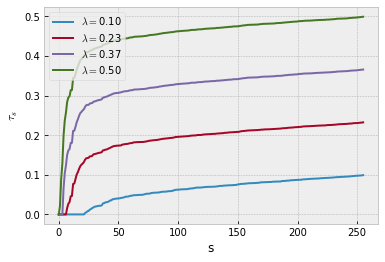

In [10]:
importlib.reload(modelDL)

mus = modelDL.get_babel(model)
Max_S = torch.sum(mus<1)

model.to(device)
LMDS = torch.linspace(0.1,.5,4).to(device)

plt.style.use('bmh')
plt.figure()
for i in range(len(LMDS)):
    model.lambd = nn.Parameter(LMDS[i])
    _,projs = modelDL.get_encoderGap(model,b_x,1)
    plt.plot(projs.cpu().numpy(),label=r'$\lambda =$%.2f'%LMDS[i].cpu().numpy())

plt.xlabel('s')
plt.ylabel(r'$\tau_s$')
plt.legend()
plt.savefig('encoder_gap_mnist_trans.pdf',transparent = True,dpi = 100)
plt.show()
